In [1]:
import seaborn as sns
import networkx as nx
from sqlalchemy import create_engine
import pandas as pd
from itertools import permutations
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot as plt 
import os


In [3]:
db_string_open_states = os.environ['DB_OPENSTATES']
db = create_engine(db_string_open_states)

In [4]:
bill_events_query = """
WITH leg_sessions AS (
SELECT *
FROM opencivicdata_legislativesession
WHERE jurisdiction_id = 'ocd-jurisdiction/country:us/state:ca/government'
AND classification = 'primary'
),

bill_events AS (
SELECT 
    bill.created_at,
    bill.updated_at,
    bill.extras,
    bill.id, 
    bill.identifier,
    bill.title,
    bill.classification[1] as classification,
    bill.subject,
    bill.from_organization_id,
    bill.legislative_session_id,
    leg_sessions.start_date as leg_start_date,
    bill.first_action_date,
    bill.latest_action_date,
    bill.latest_action_description,
    bill.latest_passage_date
    
FROM opencivicdata_bill bill
-- CA LEG SESSION IN 2019-2020
INNER JOIN leg_sessions
ON bill.legislative_session_id = leg_sessions.id
),
vote_events as (
    SELECT vote_event.created_at,
        vote_event.updated_at,
        vote_event.extras,
        vote_event.id,
        bill_events.title,
        bill_events.subject,
        bill_events.classification,
        bill_events.leg_start_date, 
        bill_events.legislative_session_id,
        vote_event.identifier, 
        vote_event.motion_text,
        vote_event.motion_classification, 
        vote_event.start_date, 
        vote_event.result, 
        vote_event.bill_id, 
        vote_event.bill_action_id, 
        vote_event.organization_id,
        vote_event.order,
        vote_event.dedupe_key
    FROM opencivicdata_voteevent as vote_event
    INNER JOIN bill_events
    ON bill_events.id = vote_event.bill_id
), 

person_vote as (
    SELECT a.*,
        vote_events.motion_text,
        vote_events.motion_classification[1] as motion_classification,
        vote_events.result,
        vote_events.leg_start_date, 
        vote_events.legislative_session_id,
        vote_events.organization_id,
        vote_events.title,
        vote_events.subject,
        vote_events.classification,
        vote_events.bill_id,
        vote_events.bill_action_id,
        uuid((regexp_match(a.voter_id, '([^/]+$)'))[1]) as voter_uuid
    FROM opencivicdata_personvote a
    INNER JOIN vote_events
    ON vote_event_id = vote_events.id
),

all_persons as (
   SELECT 
       person_vote.leg_start_date, 
       person_vote.legislative_session_id,
       person_vote.id as vote_id,
       person_vote.option,
       person_vote.voter_name,
       person_vote.title, 
       person_vote.subject,
       person_vote.classification,
       person_vote.vote_event_id,
       person_vote.motion_text,
       person_vote.motion_classification,
       person_vote.result,
       person_vote.bill_id,
       person_vote.bill_action_id,
        p.*
    FROM person_vote 
    LEFT JOIN opencivicdata_person p
    ON p.id = person_vote.voter_id
    WHERE motion_classification IS NOT NULL
)
SELECT * 
FROM all_persons
"""

vote_events_query = """
SELECT * 
FROM  
WHERE bill_id IN (previous query here, replace * with id)
, 
all_votes as (

    SELECT all_persons.*,
        v.*
    FROM all_persons 
    LEFT JOIN opencivicdata_personvotes v
    ON v.id = all_persons.personvote_id
)


"""

all_sessions_df = pd.read_sql(bill_events_query, db)

'\n\nBlanca Rubio, D\nLisa Calderon, D\nDahle, R\nGonzalez, D\nKamlager-Dove, D\nLuz Rivas, D\nLena Gonzalez, D\nRubio, D\nSmith, R\nStone, D\n'

In [5]:

all_sessions_df.loc[(all_sessions_df.voter_name.isin(['Smith','Dahle'])) & (all_sessions_df.primary_party.isna()),'primary_party'] = 'Republican'
all_sessions_df.loc[(all_sessions_df.voter_name.isin(['Rubio','Calderon','Gonzalez','Kamlager-Dove','Rivas','Stone'])) & (all_sessions_df.primary_party.isna()),'primary_party'] = 'Democratic'
all_sessions_df['legislative_session_id'] = all_sessions_df.legislative_session_id.apply(str)

all_sessions_df.groupby('primary_party').count()


,leg_start_date,legislative_session_id,vote_id,option,voter_name,title,subject,classification,vote_event_id,motion_text,...,family_name,given_name,image,gender,biography,birth_date,death_date,current_jurisdiction_id,current_role,email
primary_party,,,,,,,,,,,,,,,,,,,,,
Democratic,1177827,1177827,1177827,1177827,1177827,1177827,1177827,1177827,1177827,1177827,...,1146034,1146034,1146034,1146034,1146034,1146034,1146034,1146034,521751,1146034
Independent,6566,6566,6566,6566,6566,6566,6566,6566,6566,6566,...,6566,6566,6566,6566,6566,6566,6566,6566,6566,6566
Republican,533657,533657,533657,533657,533657,533657,533657,533657,533657,533657,...,529324,529324,529324,529324,529324,529324,529324,529324,156940,529324


In [6]:
all_sessions_df.groupby('option').count()



,leg_start_date,legislative_session_id,vote_id,voter_name,title,subject,classification,vote_event_id,motion_text,motion_classification,...,given_name,image,gender,biography,birth_date,death_date,primary_party,current_jurisdiction_id,current_role,email
option,,,,,,,,,,,,,,,,,,,,,
no,302188,302188,302188,302188,302188,302188,302188,302188,302188,302188,...,175222,175222,175222,175222,175222,175222,178063,175222,56599,175222
not voting,97630,97630,97630,97630,97630,97630,97630,97630,97630,97630,...,37555,37555,37555,37555,37555,37555,38933,37555,1798,37555
other,85580,85580,85580,85580,85580,85580,85580,85580,85580,85580,...,78127,78127,78127,78127,78127,78127,80956,78127,39322,78127
yes,2076557,2076557,2076557,2076557,2076557,2076557,2076557,2076557,2076557,2076557,...,1391020,1391020,1391020,1391020,1391020,1391020,1420098,1391020,587538,1391020


In [7]:
all_sessions_df.head()

,leg_start_date,legislative_session_id,vote_id,option,voter_name,title,subject,classification,vote_event_id,motion_text,...,given_name,image,gender,biography,birth_date,death_date,primary_party,current_jurisdiction_id,current_role,email
0,2008-12-01,bfd94a2c-f291-4943-bc4e-c06e75691029,a4e505e2-f9d9-4c43-8ab1-5cf96067e8dc,yes,De,Air discharges.,[Air discharges.],bill,ocd-vote/4baec5a5-042d-47c6-9d26-eb6414fe8f5e,Do pass.,...,None,None,None,None,None,None,None,None,None,None
1,2008-12-01,bfd94a2c-f291-4943-bc4e-c06e75691029,86a38375-8508-4eb7-8bef-67bcf05842a6,yes,Leon,Air discharges.,[Air discharges.],bill,ocd-vote/4baec5a5-042d-47c6-9d26-eb6414fe8f5e,Do pass.,...,None,None,None,None,None,None,None,None,None,None
2,2008-12-01,bfd94a2c-f291-4943-bc4e-c06e75691029,61d539d5-32a6-4899-adb9-aca9e5fbcd9c,yes,Chesbro,Air discharges.,[Air discharges.],bill,ocd-vote/4baec5a5-042d-47c6-9d26-eb6414fe8f5e,Do pass.,...,Wesley,http://assembly.ca.gov/sites/assembly.ca.gov/f...,,,,,Democratic,ocd-jurisdiction/country:us/state:ca/government,None,
3,2008-12-01,bfd94a2c-f291-4943-bc4e-c06e75691029,d457217a-4e55-45fc-9a97-0f5f9a2d76b0,yes,Hill,Air discharges.,[Air discharges.],bill,ocd-vote/4baec5a5-042d-47c6-9d26-eb6414fe8f5e,Do pass.,...,Jerry,https://www.senate.ca.gov/sites/senate.ca.gov/...,Male,,,,Democratic,ocd-jurisdiction/country:us/state:ca/government,None,
4,2008-12-01,bfd94a2c-f291-4943-bc4e-c06e75691029,548133ed-a8e0-431b-9dda-31b539abc2a1,not voting,Skinner,Air discharges.,[Air discharges.],bill,ocd-vote/4baec5a5-042d-47c6-9d26-eb6414fe8f5e,Do pass.,...,Nancy,https://www.senate.ca.gov/sites/senate.ca.gov/...,Female,,,,Democratic,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Senator', 'district': 9, 'division_...",senator.skinner@senate.ca.gov


In [8]:
all_sessions_df[all_sessions_df.legislative_session_id == 'c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e']


,leg_start_date,legislative_session_id,vote_id,option,voter_name,title,subject,classification,vote_event_id,motion_text,...,given_name,image,gender,biography,birth_date,death_date,primary_party,current_jurisdiction_id,current_role,email
30051,2020-12-07,c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e,e651327d-ec02-45a6-8781-d6d0cb427f9b,yes,Bradford,Relative to Fibromyalgia Awareness Month.,[],resolution,ocd-vote/4b77eb12-c4fb-4e84-9dda-4be1741d2d2e,3rd Reading SR37 Rubio et al.,...,Steven,https://www.senate.ca.gov/sites/senate.ca.gov/...,Male,,,,Democratic,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Senator', 'district': 35, 'division...",senator.bradford@senate.ca.gov
30052,2020-12-07,c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e,1ef0fa79-18a8-40fb-9de5-98bf9f4efe3f,yes,Durazo,Relative to Fibromyalgia Awareness Month.,[],resolution,ocd-vote/4b77eb12-c4fb-4e84-9dda-4be1741d2d2e,3rd Reading SR37 Rubio et al.,...,María Elena,https://www.senate.ca.gov/sites/senate.ca.gov/...,Female,,,,Democratic,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Senator', 'district': 24, 'division...",senator.durazo@senate.ca.gov
30053,2020-12-07,c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e,211fadbd-c691-4364-bebb-8b0fb9ac7379,yes,Grove,Relative to Fibromyalgia Awareness Month.,[],resolution,ocd-vote/4b77eb12-c4fb-4e84-9dda-4be1741d2d2e,3rd Reading SR37 Rubio et al.,...,Shannon,https://www.senate.ca.gov/sites/senate.ca.gov/...,Female,,,,Republican,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Senator', 'district': 16, 'division...",senator.grove@senate.ca.gov
30054,2020-12-07,c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e,1bcf04c6-32f3-49ac-b2d1-eb4b6cbe8960,yes,Wieckowski,Relative to Fibromyalgia Awareness Month.,[],resolution,ocd-vote/4b77eb12-c4fb-4e84-9dda-4be1741d2d2e,3rd Reading SR37 Rubio et al.,...,Bob,https://www.senate.ca.gov/sites/senate.ca.gov/...,Male,,,,Democratic,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Senator', 'district': 10, 'division...",senator.wieckowski@senate.ca.gov
30055,2020-12-07,c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e,5a2ce172-bb05-4397-bff4-59b0175b3939,yes,Laird,Relative to Fibromyalgia Awareness Month.,[],resolution,ocd-vote/4b77eb12-c4fb-4e84-9dda-4be1741d2d2e,3rd Reading SR37 Rubio et al.,...,John,https://www.senate.ca.gov/sites/senate.ca.gov/...,,,,,Democratic,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Senator', 'district': 17, 'division...",senator.laird@senate.ca.gov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561709,2020-12-07,c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e,69308a2b-8e58-42ff-9971-473ab36699bf,other,Lackey,Economic relief: COVID-19 pandemic.,[Economic relief: COVID-19 pandemic.],bill,ocd-vote/352d0c58-ebaf-4892-8b21-7256cf6e6b9c,AB 87 Ting Assembly Third Reading,...,Tom,https://www.assembly.ca.gov/sites/assembly.ca....,Male,,,,Republican,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Assemblymember', 'district': 36, 'd...",assemblymember.lackey@assembly.ca.gov
2561710,2020-12-07,c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e,232d4a1c-af5b-4e40-bd99-852947df8f48,other,Chen,Economic relief: COVID-19 pandemic.,[Economic relief: COVID-19 pandemic.],bill,ocd-vote/352d0c58-ebaf-4892-8b21-7256cf6e6b9c,AB 87 Ting Assembly Third Reading,...,Phillip,https://www.assembly.ca.gov/sites/assembly.ca....,Male,,,,Republican,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Assemblymember', 'district': 55, 'd...",assemblymember.chen@assembly.ca.gov
2561711,2020-12-07,c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e,8a98f117-3c15-4e2e-884a-8aed98437850,other,Seyarto,Economic relief: COVID-19 pandemic.,[Economic relief: COVID-19 pandemic.],bill,ocd-vote/352d0c58-ebaf-4892-8b21-7256cf6e6b9c,AB 87 Ting Assembly Third Reading,...,Kelly,https://www.assembly.ca.gov/sites/assembly.ca....,,,,,Republican,ocd-jurisdiction/country:us/state:ca/government,"{'title': 'Assemblymember', 'district': 67, 'd...",assemblymember.seyarto@assembly.ca.gov
2561712,202

/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/2582408401.py:9: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 1996/1996 [00:50<00:00, 39.51it/s]


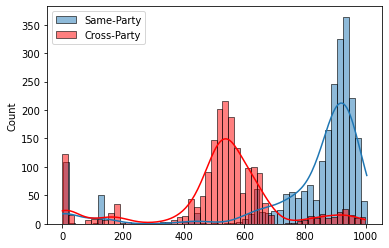

In [9]:
### We now have a df reprsenting all the votes that occurred in the session. 
### Construct a matrix of all the pairs

## Some people are missing from the db, but no names are missing. Let's assume everyone's name is unique


df = all_sessions_df[all_sessions_df.legislative_session_id == 'c1f4c7e5-064c-4d1a-9bd7-f1303eb20d4e']

party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
G = nx.Graph()
for n,party in party_dict.items():
    if party == 'Democratic':
        node_color = 'blue'
    elif party == 'Republican':
        node_color = 'red'
    else: 
        node_color='black'
    G.add_node(n,party=party,node_color=node_color)

for j,i in permutations(df.voter_name.unique(),2):
    same_party = party_dict[j] == party_dict[i]
    if same_party and party_dict[j] == 'Democratic':
        edge_color = 'blue'
    elif same_party and party_dict[j] == 'Republican':
        edge_color = 'red'
    else: 
        edge_color = 'black'
        
    G.add_edge(j,i, weight=0,same_party=same_party, edge_color=edge_color)

small_df = deepcopy(df[['vote_event_id','voter_name','option']])


for vote_event in tqdm(small_df.vote_event_id.unique()):
    vote_event_df = small_df[small_df.vote_event_id == vote_event]
    
    # define same vote as yes-yes or no-no ignore others
    for voter in vote_event_df[vote_event_df.option.isin(['yes','no'])].voter_name:
        person_option = vote_event_df[vote_event_df.voter_name == voter]['option'].values[0]
        names = vote_event_df[(vote_event_df.voter_name != voter) & (vote_event_df.option == person_option)].voter_name
        edges_to_increment = [[voter, name] for name in names]
        for n,m in edges_to_increment:
            # Since we double count in an undirect graph, add .5
            G[n][m]['weight'] += .5
        




same_party = []
different_pary = []
for u, v, data in G.edges.data():
    if data is not None:
        if data['same_party']:
            if data['weight'] > 0:
                same_party.append(data['weight'])
        else:
            if data['weight'] > 0:
                different_pary.append(data['weight'])

sns.histplot(same_party,kde=True,label='Same-Party')
sns.histplot(different_pary,kde=True,color='red', label='Cross-Party')
plt.legend()
plt.show()



# nx.draw_networkx(G,
#                  width=.001,
#                  edgelist=[(n1, n2) for n1, n2, w in G.edges(data="weight") if w < 2250])
# plt.show()
# Create 
# db.execute("CREATE TABLE IF NOT EXISTS films (title text, director text, year text)")  
# db.execute("INSERT INTO films (title, director, year) VALUES ('Doctor Strange', 'Scott Derrickson', '2016')")

# Read
# result_set = db.execute(bill_events_query)  
# for r in result_set:  
#     print(r)

# Update
# db.execute("UPDATE films SET title='Some2016Film' WHERE year='2016'")

# Delete
# db.execute("DELETE FROM films WHERE year='2016'")

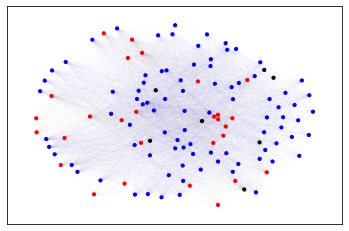

In [10]:
H = G.copy()
H.remove_edges_from([(n1, n2) for n1, n2, w in G.edges(data="weight") if w > 500])


pos = nx.spring_layout(H,k=100,iterations=1100,threshold=0.001,scale=9)

edges = []
edge_colors = []
for n1, n2, w in G.edges(data=True):
     if w['weight'] < 400:
        edges.append((n1,n2))
        edge_colors.append(w['edge_color'])

nx.draw_networkx(H,pos,
                 width=.005,
                 node_size=10,
                 node_color=[c for n,c in H.nodes('node_color')],
                 edgelist=edges,
                 edge_color=edge_colors,
                 with_labels=False
                )

plt.show()





Working on: 1998-12-07


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 1971/1971 [00:23<00:00, 82.50it/s]


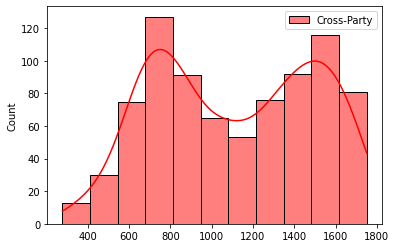

Working on: 2000-12-04


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 4147/4147 [02:14<00:00, 30.94it/s]


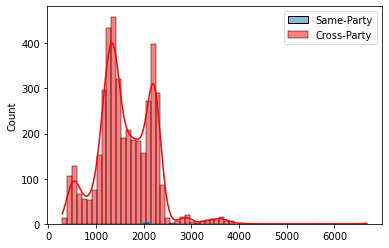

/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()


Working on: 2002-12-02


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 90.24it/s]


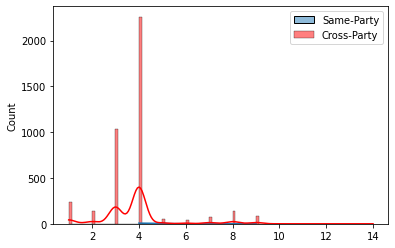

Working on: 2004-12-06


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|█████████████████████████████████████████████████████████████████████████████████| 930/930 [00:16<00:00, 54.84it/s]


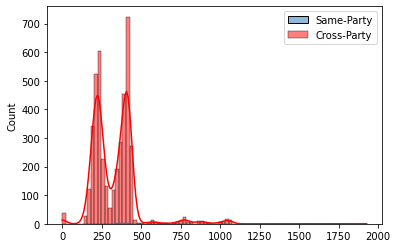

Working on: 2006-12-04


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 4158/4158 [02:16<00:00, 30.43it/s]


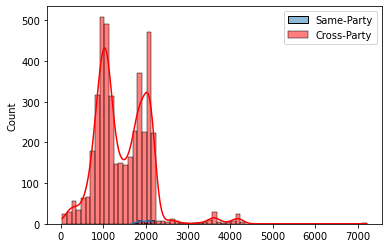

Working on: 2008-12-01


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|█████████████████████████████████████████████████████████████████████████████| 17679/17679 [15:43<00:00, 18.74it/s]


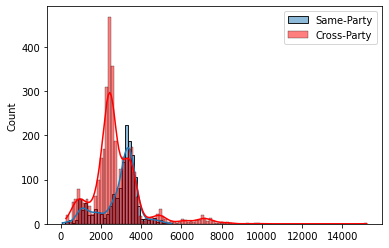

Working on: 2010-12-06


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 3824/3824 [02:09<00:00, 29.46it/s]


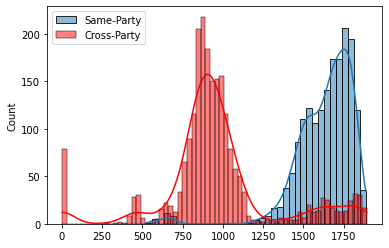

Working on: 2012-12-03


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 4079/4079 [02:27<00:00, 27.71it/s]


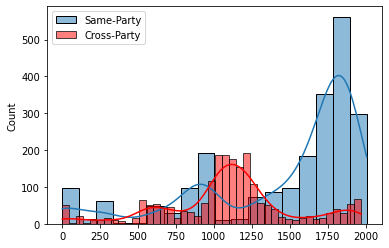

Working on: 2015-01-01


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 4188/4188 [02:39<00:00, 26.29it/s]


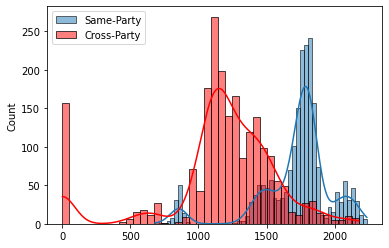

Working on: 2016-12-05


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 4351/4351 [02:54<00:00, 24.98it/s]


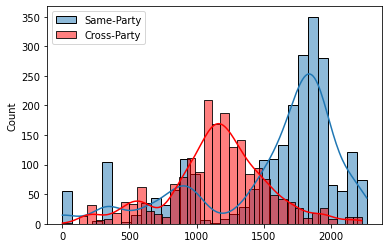

Working on: 2018-12-03


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 3090/3090 [01:42<00:00, 30.11it/s]


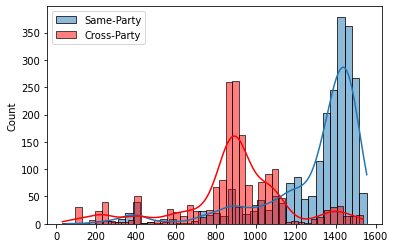

Working on: 2020-12-07


/var/folders/fs/j53400wd7330t2k_h5fv9s9h0000gn/T/ipykernel_50350/194630475.py:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
100%|███████████████████████████████████████████████████████████████████████████████| 1996/1996 [00:53<00:00, 37.01it/s]


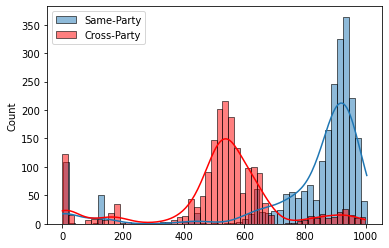

In [11]:
### Iterate through all 


### We now have a df reprsenting all the votes that occurred in the session. 
### Construct a matrix of all the pairs

## Some people are missing from the db, but no names are missing. Let's assume everyone's name is unique
sessions = all_sessions_df.groupby(['legislative_session_id','leg_start_date']).count().reset_index().sort_values('leg_start_date')


for id_,start_date in sessions[['legislative_session_id','leg_start_date']].values:
    print(f"Working on: {start_date}")

    df = all_sessions_df[all_sessions_df.legislative_session_id == id_]

    party_dict = df.groupby(['voter_name']).max()['primary_party'].to_dict()
    G = nx.Graph()
    for n,party in party_dict.items():
        if party == 'Democratic':
            node_color = 'blue'
        elif party == 'Republican':
            node_color = 'red'
        else: 
            node_color='black'
        G.add_node(n,party=party,node_color=node_color)

    for j,i in permutations(df.voter_name.unique(),2):
        same_party = party_dict[j] == party_dict[i]
        if same_party and party_dict[j] == 'Democratic':
            edge_color = 'blue'
        elif same_party and party_dict[j] == 'Republican':
            edge_color = 'red'
        else: 
            edge_color = 'black'

        G.add_edge(j,i, weight=0,same_party=same_party, edge_color=edge_color)

    small_df = deepcopy(df[['vote_event_id','voter_name','option']])


    for vote_event in tqdm(small_df.vote_event_id.unique()):
        vote_event_df = small_df[small_df.vote_event_id == vote_event]

        # define same vote as yes-yes or no-no ignore others
        for voter in vote_event_df[vote_event_df.option.isin(['yes','no'])].voter_name:
            person_option = vote_event_df[vote_event_df.voter_name == voter]['option'].values[0]
            names = vote_event_df[(vote_event_df.voter_name != voter) & (vote_event_df.option == person_option)].voter_name
            edges_to_increment = [[voter, name] for name in names]
            for n,m in edges_to_increment:
                # Since we double count in an undirect graph, add .5
                G[n][m]['weight'] += .5


    same_party = []
    different_pary = []
    for u, v, data in G.edges.data():
        if data is not None:
            if data['same_party']:
                if data['weight'] > 0:
                    same_party.append(data['weight'])
            else:
                if data['weight'] > 0:
                    different_pary.append(data['weight'])

    sns.histplot(same_party,kde=True,label='Same-Party')
    sns.histplot(different_pary,kde=True,color='red', label='Cross-Party')
    plt.legend()
    plt.show()


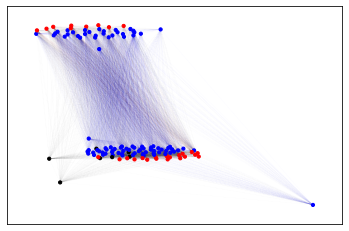

In [12]:
#G.remove_edges_from([(n1, n2) for n1, n2, w in G.edges(data="weight") if w < 700])

pos = nx.spring_layout(G,k=2,iterations=1100,threshold=0.0001,scale=5)

edges = []
edge_colors = []
for n1, n2, w in G.edges(data=True):
     if w['weight'] < 700:
        edges.append((n1,n2))
        edge_colors.append(w['edge_color'])

nx.draw_networkx(G,pos,
                 width=.005,
                 node_size=10,
                 node_color=[c for n,c in G.nodes('node_color')],
                 edgelist=edges,
                 edge_color=edge_colors,
                 with_labels=False
                )
plt.show()




# nx.draw_networkx(G,
#                  width=.001,
#                  edgelist=[(n1, n2) for n1, n2, w in G.edges(data="weight") if w < 2250])
# plt.show()
# Create 
# db.execute("CREATE TABLE IF NOT EXISTS films (title text, director text, year text)")  
# db.execute("INSERT INTO films (title, director, year) VALUES ('Doctor Strange', 'Scott Derrickson', '2016')")

# Read
# result_set = db.execute(bill_events_query)  
# for r in result_set:  
#     print(r)

# Update
# db.execute("UPDATE films SET title='Some2016Film' WHERE year='2016'")

# Delete
# db.execute("DELETE FROM films WHERE year='2016'")